# Case Técnico de Data Analysis - iFood

In [1]:
# Instruções para execução
# 1. Instalar o Python 3.8 ou superior
# 2. Instalar o pip (gerenciador de pacotes do Python) 
# 3. Instalar as bibliotecas necessárias com o comando:
##    pip install -r requirements.txt
# 4. Executar o script na ordem

## Importação dos pacotes necessários

In [2]:
import json
import pandas as pd
import pyspark as ps
import os
import gzip
pd.options.display.float_format = '{:.2f}'.format  #Essa linha foi adicionada posteriormente para formatar os números com duas casas decimais e tirar notações científicas
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob

## Importação das bases de dados

In [3]:
# A importação da base de ordes tive que realizar manualmente, pois o arquivo é muito grande e não consegui fazer o download dele diretamente do S3.

In [4]:
# Caminhos
entrada = r"C:\Users\Ítalo\Desktop\Estudos\case_tec_data\dados_ifood\order.json.gz"
saida_dir = r"C:\Users\Ítalo\Desktop\Estudos\case_tec_data\dados_ifood\parquet_chunks"

# Cria pasta de saída se não existir
os.makedirs(saida_dir, exist_ok=True)

batch_size = 100_000  # Tamanho do bloco
dados = []
batch_id = 0

with gzip.open(entrada, 'rt', encoding='utf-8') as f:
    for i, linha in enumerate(f, 1):  # começa do 1 pra debug elegante
        try:
            dados.append(json.loads(linha))
        except Exception as e:
            print(f"Erro na linha {i}: {e}")

        # Quando atingir o tamanho do lote, salva e limpa
        if i % batch_size == 0:
            df_temp = pd.DataFrame(dados)
            # Salva como parquet usando pyarrow
            df_temp.to_parquet(os.path.join(saida_dir, f"order_chunk_{batch_id}.parquet"), engine='pyarrow')
            print(f"Salvo chunk {batch_id} com {len(df_temp)} linhas.")
            dados = []
            batch_id += 1

# Salva o último pedaço, se sobrou algo
if dados:
    df_temp = pd.DataFrame(dados)
    # Salva como parquet usando pyarrow
    df_temp.to_parquet(os.path.join(saida_dir, f"order_chunk_{batch_id}.parquet"), engine='pyarrow')
    print(f"Salvo chunk {batch_id} com {len(df_temp)} linhas.")

Salvo chunk 0 com 100000 linhas.
Salvo chunk 1 com 100000 linhas.
Salvo chunk 2 com 100000 linhas.
Salvo chunk 3 com 100000 linhas.
Salvo chunk 4 com 100000 linhas.
Salvo chunk 5 com 100000 linhas.
Salvo chunk 6 com 100000 linhas.
Salvo chunk 7 com 100000 linhas.
Salvo chunk 8 com 100000 linhas.
Salvo chunk 9 com 100000 linhas.
Salvo chunk 10 com 100000 linhas.
Salvo chunk 11 com 100000 linhas.
Salvo chunk 12 com 100000 linhas.
Salvo chunk 13 com 100000 linhas.
Salvo chunk 14 com 100000 linhas.
Salvo chunk 15 com 100000 linhas.
Salvo chunk 16 com 100000 linhas.
Salvo chunk 17 com 100000 linhas.
Salvo chunk 18 com 100000 linhas.
Salvo chunk 19 com 100000 linhas.
Salvo chunk 20 com 100000 linhas.
Salvo chunk 21 com 100000 linhas.
Salvo chunk 22 com 100000 linhas.
Salvo chunk 23 com 100000 linhas.
Salvo chunk 24 com 100000 linhas.
Salvo chunk 25 com 100000 linhas.
Salvo chunk 26 com 100000 linhas.
Salvo chunk 27 com 100000 linhas.
Salvo chunk 28 com 100000 linhas.
Salvo chunk 29 com 10000

In [5]:
# Lista todos os arquivos .parquet no diretório de saída
arquivos = glob.glob(saida_dir + r"\order_chunk_*.parquet")

# Concatena os arquivos parquet em um único DataFrame
df_orders = pd.concat([pd.read_parquet(arquivo, engine='pyarrow') for arquivo in arquivos], ignore_index=True)

# Exibe o tamanho e as primeiras linhas
print(df_orders.shape)
df_orders.head()

(3670826, 22)


,cpf,customer_id,customer_name,delivery_address_city,delivery_address_country,delivery_address_district,delivery_address_external_id,delivery_address_latitude,delivery_address_longitude,delivery_address_state,...,merchant_id,merchant_latitude,merchant_longitude,merchant_timezone,order_created_at,order_id,order_scheduled,order_total_amount,origin_platform,order_scheduled_date
0,80532101763,7ba88a68bb2a3504c6bd37a707af57a0b8d6e110a551c7...,GUSTAVO,FRANCA,BR,JARDIM ESPRAIADO,6736655,-47.39,-20.55,SP,...,a992a079a651e699d9149423761df2427c0e3af0a2a1b5...,-47.39,-20.55,America/Sao_Paulo,2019-01-17T22:50:06.000Z,33e0612d62e5eb42aba15b58413137e441fbe906de2feb...,False,46.00,ANDROID,None
1,43352103961,078acecdcf7fa89d356bfa349f14a8219db1ee161ce28a...,MICHELLE,SANTOS,BR,CAMPO GRANDE,8759216,-46.34,-23.96,SP,...,5152f28ee0518b8803ccf0a4096eb2ff8b81e9491861c9...,-46.34,-23.96,America/Sao_Paulo,2019-01-17T17:51:26.000Z,148c4353a2952f3fe7973547283265eb22b575fb712ed2...,False,104.50,ANDROID,None
2,38650991217,0e38a3237b5946e8ab2367b4f1a3ae6e77f1e215bc760c...,VICTOR,GUARULHOS,BR,JARDIM ROSSI,8765930,-46.53,-23.44,SP,...,b6096419455c35d06105a5ef0d25c51f9dd40e1e99ac33...,-46.53,-23.44,America/Sao_Paulo,2019-01-17T22:53:47.000Z,c37e495a91b498bb7b70a9e09ac115d0cdd443f152dc11...,False,35.00,IOS,None
3,63579726866,cab1a004b7206d07910092c515a79834fea0a03d7d9054...,ANNIE,SAO PAULO,BR,PARQUE SAO JORGE,7834087,-46.57,-23.53,SP,...,082bfdcdf6ccdc343e3c4d25ee376b5b6ca7e96ad8b04e...,-46.57,-23.53,America/Sao_Paulo,2019-01-17T23:56:53.000Z,b4df94142d21354611247da9ca94f870c09b93989b531a...,False,40.80,IOS,None
4,90617788806,aa7edf5b166b8c843aec3b96dc561222888734f3879123...,DANIEL,VITORIA,BR,JARDIM CAMBURI,7211683,-40.27,-20.25,ES,...,d7adb764bac29ccb77fb8f746ffbd531bf05ec30a7e130...,-40.27,-20.25,America/Sao_Paulo,2019-01-17T23:40:53.000Z,4ff64b33b272c1886df21b63272220af6a82d1667dba70...,False,48.50,ANDROID,None


In [6]:
# Importando costumers

# Caminho para o arquivo CSV compactado
caminho_consumer = r"C:\Users\Ítalo\Desktop\Estudos\case_tec_data\dados_ifood\consumer.csv.gz"

# Lê o arquivo CSV compactado com pandas
df_consumer = pd.read_csv(caminho_consumer, compression='gzip')

# Exibe as primeiras linhas
print("Consumer DataFrame:")
df_consumer.head()

Consumer DataFrame:


,customer_id,language,created_at,active,customer_name,customer_phone_area,customer_phone_number
0,e8cc60860e09c0bb19610b06ced69c973eb83982cfc98e...,pt-br,2018-04-05T14:49:18.165Z,True,NUNO,46,816135924
1,a2834a38a9876cf74e016524dd2e8c1f010ee12b2b684d...,pt-br,2018-01-14T21:40:02.141Z,True,ADRIELLY,59,231330577
2,41e1051728eba13341136d67d0757f8d8cc44b2a405b71...,pt-br,2018-01-07T03:47:15.554Z,True,PAULA,62,347597883
3,8e7c1dcb64edf95c935147f6d560cb068c44714cb1b21b...,pt-br,2018-01-10T22:17:08.160Z,True,HELTON,13,719366842
4,7823d4cf4150c5daeae0bd799206852fc123bdef0cf5d1...,pt-br,2018-04-06T00:16:20.935Z,True,WENDER,76,543232158


In [7]:
# Importando restaurant

# Caminho para o arquivo CSV compactado
caminho_restaurant = r"C:\Users\Ítalo\Desktop\Estudos\case_tec_data\dados_ifood\restaurant.csv.gz"

# Lê o arquivo CSV compactado com pandas
df_restaurant = pd.read_csv(caminho_restaurant, compression='gzip')

# Exibe as primeiras linhas
print("Restaurant DataFrame:")
df_restaurant.head()

Restaurant DataFrame:


,id,created_at,enabled,price_range,average_ticket,takeout_time,delivery_time,minimum_order_value,merchant_zip_code,merchant_city,merchant_state,merchant_country
0,d19ff6fca6288939bff073ad0a119d25c0365c407e9e5d...,2017-01-23T12:52:30.910Z,False,3,60.00,0,50.00,30.00,14025,RIBEIRAO PRETO,SP,BR
1,631df0985fdbbaf27b9b031a8f381924e3483833385748...,2017-01-20T13:14:48.286Z,True,3,60.00,0,0.00,30.00,50180,SAO PAULO,SP,BR
2,135c5c4ae4c1ec1fdc23e8c649f313e39be8db913d8bc5...,2017-01-23T12:46:33.457Z,True,5,100.00,0,45.00,10.00,23090,RIO DE JANEIRO,RJ,BR
3,d26f84c470451f752bef036c55517b6d9950d41806f10e...,2017-01-20T13:15:04.806Z,True,3,80.00,0,0.00,18.90,40255,SALVADOR,BA,BR
4,97b9884600ea7192314580d9115f8882b8634f5aa201ff...,2017-01-20T13:14:27.701Z,True,3,60.00,0,0.00,25.00,64600,BARUERI,SP,BR


In [8]:
# Importando ab_test_ref

# Caminho para o arquivo CSV compactado
caminho_ab_test = r"C:\Users\Ítalo\Desktop\Estudos\case_tec_data\dados_ifood\ab_test_ref.csv"

# Lê o arquivo CSV compactado com pandas
df_ab_test = pd.read_csv(caminho_ab_test)

# Exibe as primeiras linhas
print("A/B Test DataFrame:")
df_ab_test.head()

A/B Test DataFrame:


,customer_id,is_target
0,755e1fa18f25caec5edffb188b13fd844b2af8cf5adedc...,target
1,b821aa8372b8e5b82cdc283742757df8c45eecdd72adf4...,control
2,d425d6ee4c9d4e211b71da8fc60bf6c5336b2ea9af9cc0...,control
3,6a7089eea0a5dc294fbccd4fa24d0d84a90c1cc12e829c...,target
4,dad6b7e222bab31c0332b0ccd9fa5dbd147008facd268f...,control


### Criando uma data frame analitico com as informações enriquecidas

In [9]:
df_anl = pd.merge(df_orders, df_consumer, left_on='customer_id', right_on='customer_id', how='outer')

In [10]:
df_anl = df_anl.drop(columns=['customer_name_y'])

In [11]:
df_anl_inter = pd.merge(df_anl, df_ab_test, left_on='customer_id', right_on='customer_id', how='outer')

In [12]:
df_anl_comp = pd.merge(df_anl_inter, df_restaurant, left_on='merchant_id', right_on='id', how='outer')

In [13]:
df_anl_comp.info()
df_anl_comp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3670827 entries, 0 to 3670826
Data columns (total 40 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   cpf                           object 
 1   customer_id                   object 
 2   customer_name_x               object 
 3   delivery_address_city         object 
 4   delivery_address_country      object 
 5   delivery_address_district     object 
 6   delivery_address_external_id  object 
 7   delivery_address_latitude     object 
 8   delivery_address_longitude    object 
 9   delivery_address_state        object 
 10  delivery_address_zip_code     object 
 11  items                         object 
 12  merchant_id                   object 
 13  merchant_latitude             object 
 14  merchant_longitude            object 
 15  merchant_timezone             object 
 16  order_created_at              object 
 17  order_id                      object 
 18  order_scheduled       

,cpf,customer_id,customer_name_x,delivery_address_city,delivery_address_country,delivery_address_district,delivery_address_external_id,delivery_address_latitude,delivery_address_longitude,delivery_address_state,...,enabled,price_range,average_ticket,takeout_time,delivery_time,minimum_order_value,merchant_zip_code,merchant_city,merchant_state,merchant_country
0,77672324923,004f93d3195c0d647b24aa1d0748f91ee6d366fe36af51...,CAMILA,SAO PAULO,BR,VILA CORDEIRO,8653503,-46.69,-23.62,SP,...,False,3,80.00,30,10.00,15.00,54220,SAO PAULO,SP,BR
1,44776738771,004f93d3195c0d647b24aa1d0748f91ee6d366fe36af51...,CAMILA,SAO PAULO,BR,VILA CORDEIRO,8653503,-46.69,-23.62,SP,...,False,3,80.00,30,10.00,15.00,54220,SAO PAULO,SP,BR
2,87259021118,00a6775e189a862d1aa4baf6361c6fef89e7c147e4f51b...,SINEIVA,SAO PAULO,BR,CONSOLACAO,9114346,-46.65,-23.55,SP,...,False,3,80.00,30,10.00,15.00,54220,SAO PAULO,SP,BR
3,18719336884,00a6775e189a862d1aa4baf6361c6fef89e7c147e4f51b...,SINEIVA,SAO PAULO,BR,CONSOLACAO,9114346,-46.65,-23.55,SP,...,False,3,80.00,30,10.00,15.00,54220,SAO PAULO,SP,BR
4,00557204482,00cd773e7f6881377ef5423847d7e9e9dd04f5f1753c19...,MIGUEL,SAO PAULO,BR,VILA MADALENA,4985965,-46.69,-23.55,SP,...,False,3,80.00,30,10.00,15.00,54220,SAO PAULO,SP,BR


In [14]:
# Dividir o DataFrame entre grupo de teste e controle
grupo_teste = df_anl_comp[df_anl_comp['is_target'] == 'target']
grupo_controle = df_anl_comp[df_anl_comp['is_target'] == 'control']

### Realizando os cálculos necessários para os indicadores

In [15]:
grupo_teste.head()

,cpf,customer_id,customer_name_x,delivery_address_city,delivery_address_country,delivery_address_district,delivery_address_external_id,delivery_address_latitude,delivery_address_longitude,delivery_address_state,...,enabled,price_range,average_ticket,takeout_time,delivery_time,minimum_order_value,merchant_zip_code,merchant_city,merchant_state,merchant_country
0,77672324923,004f93d3195c0d647b24aa1d0748f91ee6d366fe36af51...,CAMILA,SAO PAULO,BR,VILA CORDEIRO,8653503,-46.69,-23.62,SP,...,False,3,80.00,30,10.00,15.00,54220,SAO PAULO,SP,BR
1,44776738771,004f93d3195c0d647b24aa1d0748f91ee6d366fe36af51...,CAMILA,SAO PAULO,BR,VILA CORDEIRO,8653503,-46.69,-23.62,SP,...,False,3,80.00,30,10.00,15.00,54220,SAO PAULO,SP,BR
2,87259021118,00a6775e189a862d1aa4baf6361c6fef89e7c147e4f51b...,SINEIVA,SAO PAULO,BR,CONSOLACAO,9114346,-46.65,-23.55,SP,...,False,3,80.00,30,10.00,15.00,54220,SAO PAULO,SP,BR
3,18719336884,00a6775e189a862d1aa4baf6361c6fef89e7c147e4f51b...,SINEIVA,SAO PAULO,BR,CONSOLACAO,9114346,-46.65,-23.55,SP,...,False,3,80.00,30,10.00,15.00,54220,SAO PAULO,SP,BR
4,00557204482,00cd773e7f6881377ef5423847d7e9e9dd04f5f1753c19...,MIGUEL,SAO PAULO,BR,VILA MADALENA,4985965,-46.69,-23.55,SP,...,False,3,80.00,30,10.00,15.00,54220,SAO PAULO,SP,BR


In [16]:
# Taxa de conversão
taxa_conversao_teste = grupo_teste[grupo_teste['order_id'].notnull()]['customer_id'].nunique() / grupo_teste['customer_id'].nunique()
taxa_conversao_controle = grupo_controle[grupo_controle['order_id'].notnull()]['customer_id'].nunique() / grupo_controle['customer_id'].nunique()
print(f"Taxa de conversão do grupo de teste: {taxa_conversao_teste:.2%}")
print(f"Taxa de conversão do grupo de controle: {taxa_conversao_controle:.2%}")


Taxa de conversão do grupo de teste: 100.00%
Taxa de conversão do grupo de controle: 100.00%


In [17]:
grupo_teste[grupo_teste['order_id'].notnull()]['customer_id'].nunique()

445924

In [18]:
# AOV (Valor médio de pedido)
aov_teste = grupo_teste.groupby('customer_id')['order_total_amount'].sum().mean()
aov_controle = grupo_controle.groupby('customer_id')['order_total_amount'].sum().mean()
print(f"AOV do grupo de teste: {aov_teste:.2f}")
print(f"AOV do grupo de controle: {aov_controle:.2f}")

AOV do grupo de teste: 228.76
AOV do grupo de controle: 202.67


In [19]:
# Taxa de Retenção (Usuários com mais de um pedido)
retencao_teste = grupo_teste.groupby('customer_id').size().gt(1).mean()
retencao_controle = grupo_controle.groupby('customer_id').size().gt(1).mean()
print(f"Taxa de retenção do grupo de teste: {retencao_teste:.2%}") 
print(f"Taxa de retenção do grupo de controle: {retencao_controle:.2%}")

Taxa de retenção do grupo de teste: 79.51%
Taxa de retenção do grupo de controle: 74.70%


In [20]:
# Número médio de pedidos por usuário
pedidos_por_usuario_teste = grupo_teste.groupby('customer_id').size().mean()
pedidos_por_usuario_controle = grupo_controle.groupby('customer_id').size().mean()
print(f"Número médio de pedidos por usuário no grupo de teste: {pedidos_por_usuario_teste:.2f}")
print(f"Número médio de pedidos por usuário no grupo de controle: {pedidos_por_usuario_controle:.2f}")

Número médio de pedidos por usuário no grupo de teste: 4.79
Número médio de pedidos por usuário no grupo de controle: 4.23


### Realização do T-Teste para comparar as métricas entre os grupos de teste e controle

In [21]:
# T-Teste para AOV
# Calcular o AOV (Valor médio de pedido) para cada grupo

aov_teste = grupo_teste.groupby('customer_id')['order_total_amount'].sum() / grupo_teste.groupby('customer_id').size()
aov_controle = grupo_controle.groupby('customer_id')['order_total_amount'].sum() / grupo_controle.groupby('customer_id').size()

# Remove infs e nans
aov_teste = aov_teste.replace([np.inf, -np.inf], np.nan).dropna()
aov_controle = aov_controle.replace([np.inf, -np.inf], np.nan).dropna()

t_stat, p_value_aov = stats.ttest_ind(aov_teste, aov_controle)

In [22]:
# T-Teste para retenção
# Calcular a taxa de retenção para cada grupo
retencao_teste = (grupo_teste.groupby('customer_id').size() > 1).astype(int)
retencao_controle = (grupo_controle.groupby('customer_id').size() > 1).astype(int)

t_stat, p_value_retencao = stats.ttest_ind(retencao_teste, retencao_controle, equal_var=False)

In [23]:
# T-Teste para pedidos por usuário
# Calcular o número de pedidos por usuário para cada grupo
t_stat, p_value_pedidos = stats.ttest_ind(grupo_teste.groupby('customer_id').size(), grupo_controle.groupby('customer_id').size())

In [24]:
# Teste T - Comparando as métricas
print("\nResultados do Teste T:")
print("AOV p-value: {:.4f}".format(p_value_aov))
print("Taxa de Retenção p-value: {:.4f}".format(p_value_retencao))
print("Pedidos por Usuário p-value: {:.4f}".format(p_value_pedidos))


Resultados do Teste T:
AOV p-value: 0.3795
Taxa de Retenção p-value: 0.0000
Pedidos por Usuário p-value: 0.0000


In [25]:
# Indicadores selecionados

# AOV  - média de valor por pedido
# Taxa de Retenção - percentual de usuários que retornaram para fazer mais de um pedido
# Pedidos por Usuário  - média de pedidos por usuário

# Esses 3 tiveram p-value menor que 0.05, o que indica que há diferença significativa entre os grupos de teste e controle.
# Isso sugere que a campanha de marketing teve um impacto positivo nas métricas de desempenho.

### Analisando viabilidade Financeira da campanha de marketing

1. Premissas adotadas
A margem de contribuição é proporcional ao GMV (Gross Merchandise Value).

O iFood deseja aumentar o GMV por usuário (volume financeiro transacionado).

O número de pedidos por usuário indica engajamento.

Se o grupo teste tiver GMV médio significativamente maior por usuário, há viabilidade de crescimento.

In [26]:
# GMV total por usuário
gmv_teste_por_user = grupo_teste.groupby('customer_id')['order_total_amount'].sum()
gmv_controle_por_user = grupo_controle.groupby('customer_id')['order_total_amount'].sum()

# T-teste
t_stat, p_value_gmv = stats.ttest_ind(gmv_teste_por_user, gmv_controle_por_user)

print(f"GMV médio por usuário - p-value: {p_value_gmv:.5f}")

GMV médio por usuário - p-value: 0.00000


In [27]:
# Pedidos por usuário

pedidos_teste = grupo_teste.groupby('customer_id').size()
pedidos_controle = grupo_controle.groupby('customer_id').size()

t_stat, p_value_pedidos = stats.ttest_ind(pedidos_teste, pedidos_controle, equal_var=False)

print(f"Pedidos por usuário - p-value: {p_value_pedidos:.4f}")

Pedidos por usuário - p-value: 0.0000


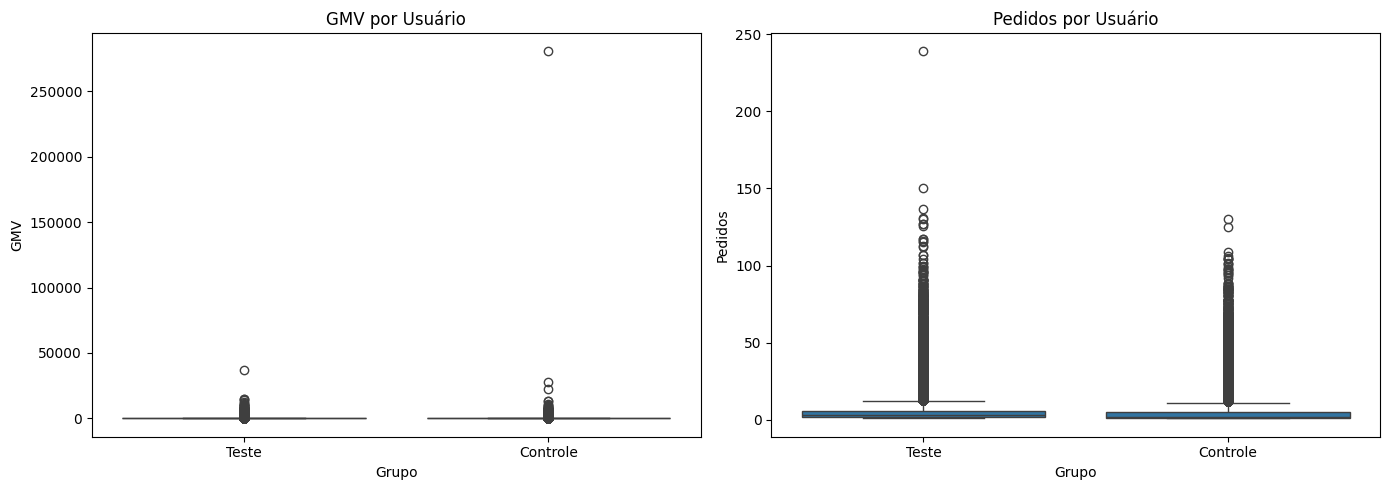

In [28]:
# Prepara DataFrame para visualização
df_viz = pd.DataFrame({
    'GMV': pd.concat([gmv_teste_por_user, gmv_controle_por_user]),
    'Pedidos': pd.concat([pedidos_teste, pedidos_controle]),
    'Grupo': ['Teste'] * len(gmv_teste_por_user) + ['Controle'] * len(gmv_controle_por_user)
})

# Gráficos
plt.figure(figsize=(14, 5))

# Boxplot GMV
plt.subplot(1, 2, 1)
sns.boxplot(data=df_viz, x='Grupo', y='GMV')
plt.title('GMV por Usuário')

# Boxplot Pedidos
plt.subplot(1, 2, 2)
sns.boxplot(data=df_viz, x='Grupo', y='Pedidos')
plt.title('Pedidos por Usuário')

plt.tight_layout()
plt.show()

c) Recomendações de melhoria e nova proposta de teste A/B
1. Oportunidades de Melhoria Identificadas
Com base na análise realizada, algumas limitações e pontos de atenção foram detectados na campanha atual:

Oferta homogênea: Todos os usuários do grupo teste receberam o mesmo cupom, sem considerar comportamentos de consumo, frequência ou valor médio gasto.

Foco limitado nas métricas de sucesso: A avaliação se concentrou em métricas agregadas, como GMV e pedidos por usuário, sem diferenciar efeitos por segmento.

Ausência de alavancas de personalização: A campanha ignorou perfis como "usuários inativos", "usuários frequentes" ou "usuários de ticket alto".

2. Hipóteses para Novo Teste A/B
Com base nos insights e dados, recomendamos desenhar uma nova estratégia de cupons com hipóteses segmentadas. Exemplo:

Hipótese 1: Cupons maiores (ex: R$20) geram maior reativação de usuários inativos do que cupons padrão (ex: R$10).

Hipótese 2: Usuários de ticket médio alto (>R$50 por pedido) respondem melhor a cupons proporcionais (ex: 20% off).

Hipótese 3: Enviar cupons em horários de pico (ex: jantares, fim de semana) aumenta a taxa de uso.

Hipótese 4: Enviar cupons maiores para usuários não ativos, como tentativa de reativação